<a href="https://colab.research.google.com/github/simranjeet567/Detection-of-Suspicious-URL/blob/main/Detection_of_Suspicious_URL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os

In [2]:
# prompt: change my current working directory to /content/drive/MyDrive/Colab Notebooks/

import os

# Get the current working directory.
cwd = os.getcwd()

# Change the current working directory to the desired directory.
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

# Print the new current working directory.
print(os.getcwd())


/content/drive/MyDrive/Colab Notebooks


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/malicious_phish.csv")

In [4]:
df.head(20)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [5]:
# prompt: check if tld is installed

try:
  import tld
except ImportError:
  !pip install tld
  import tld

# Now you can use the tld module.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 5.0 MB/s eta 0:00:00


In [6]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tld import get_tld, is_tld

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [8]:
df.isnull().sum()

url     0
type    0
dtype: int64

In [9]:
df


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [10]:
count = df.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malicious      32520
Name: type, dtype: int64

Text(0.5, 1.0, 'Count of different types of URLs')

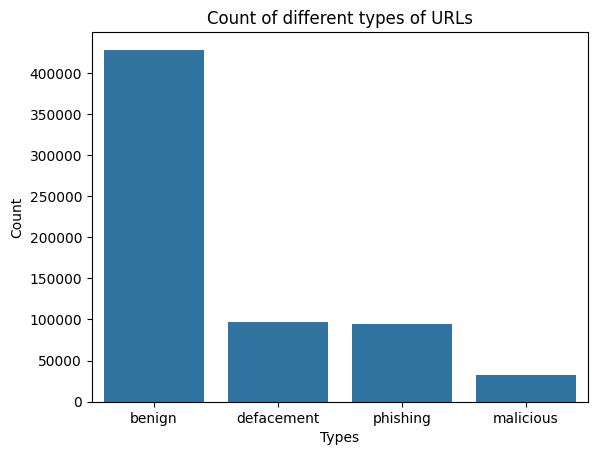

In [11]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');
plt.title('Count of different types of URLs')

In [12]:
df['url'] = df['url'].replace('www.', '', regex=True)
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [13]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [14]:
dict = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malicious":3}}
df['Category'] = df['type']
df = df.replace(dict)

In [15]:
df['url_length'] = df['url'].apply(lambda x: len(str(x)))

def processTLD(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        primary_domain= res.parsed_url.netloc
    except :
        primary_domain= None
    return primary_domain

df['domain'] = df['url'].apply(lambda i: processTLD(i))

df.head()

,url,type,Category,url_length,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [16]:
df

,url,type,Category,url_length,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org


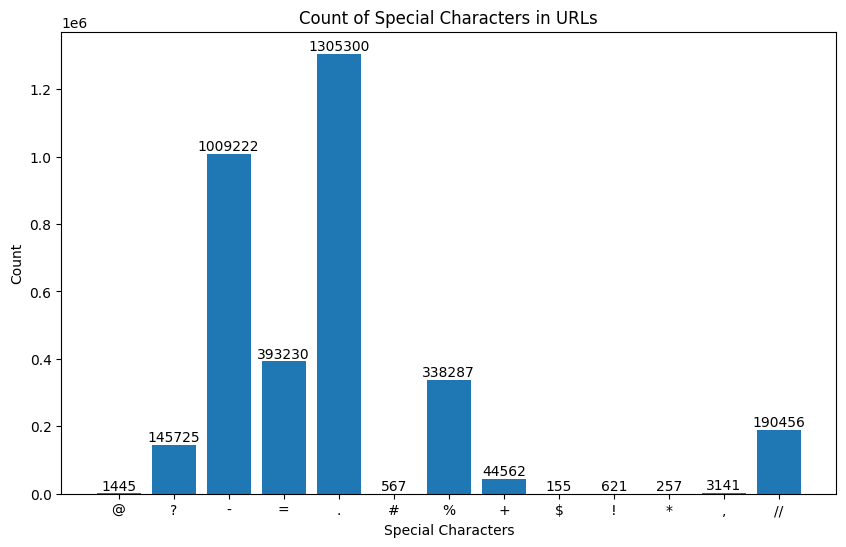

,url,type,Category,url_length,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,0,0,0,0,3,0,0,0,0,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,0,0,2,0,2,0,0,0,0,0,0,0,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,0,0,0,0,1,0,0,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,0,0,0,0,2,0,0,0,0,0,0,0,0


In [17]:
featureArray = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
countOfSpecialCharacterArray = []
for x in featureArray:
    df[x] = df['url'].apply(lambda i: i.count(x))
    countSpecialCharacter = df['url'].apply(lambda i: i.count(x)).sum()
    countOfSpecialCharacterArray.append(countSpecialCharacter)

plt.figure(figsize=(10, 6))
bars=plt.bar(featureArray,  countOfSpecialCharacterArray)
plt.xlabel('Special Characters')
plt.ylabel('Count')
plt.title('Count of Special Characters in URLs')
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

for bar, count in zip(bars, countOfSpecialCharacterArray):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(count), ha='center', va='bottom')

plt.show()



df

In [18]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

Text(0.5, 1.0, 'Count of abnormal URLs')

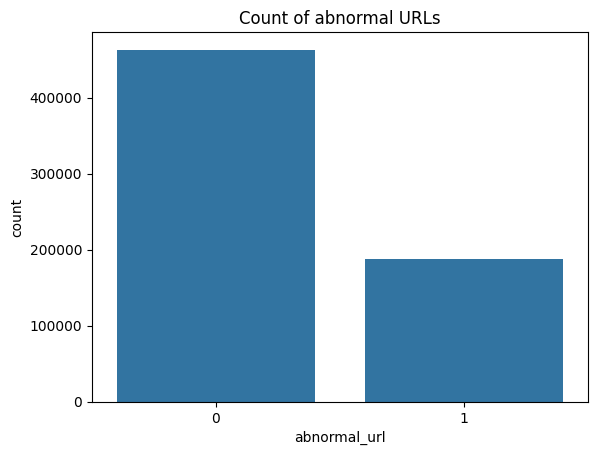

In [19]:
sns.countplot(x='abnormal_url', data=df);
plt.title('Count of abnormal URLs')

In [20]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [21]:
df['https'] = df['url'].apply(lambda i: httpSecure(i))

Text(0.5, 1.0, 'Count of HTTPS Protocal')

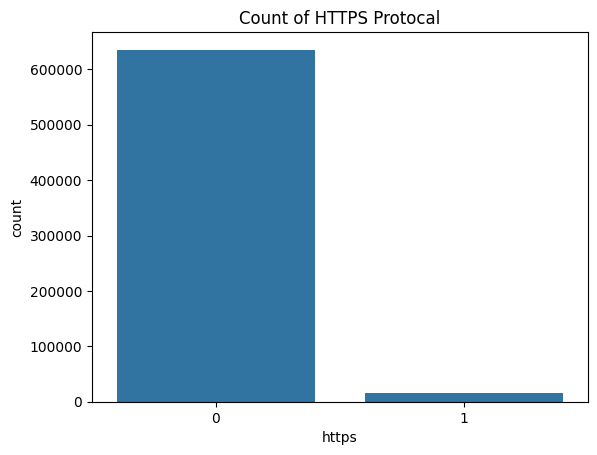

In [22]:
sns.countplot(x='https', data=df);
plt.title('Count of HTTPS Protocal')

In [23]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [24]:
df['digits']= df['url'].apply(lambda i: digit_count(i))
df.head()

,url,type,Category,url_length,domain,@,?,-,=,.,...,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,0,1,1,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,0,1,1,0,22


In [25]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['letters']= df['url'].apply(lambda i: letter_count(i))

In [26]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [27]:
df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))

df

,url,type,Category,url_length,domain,@,?,-,=,.,...,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,1,1,0,22,199,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,0,0,0,0,3,...,0,0,0,0,0,0,0,12,21,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,0,0,2,0,2,...,0,0,0,0,0,0,0,7,29,1
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,0,0,0,0,1,...,0,0,0,0,0,0,0,3,30,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,36,0


Text(0.5, 1.0, 'Count of the usage of URL shortening service')

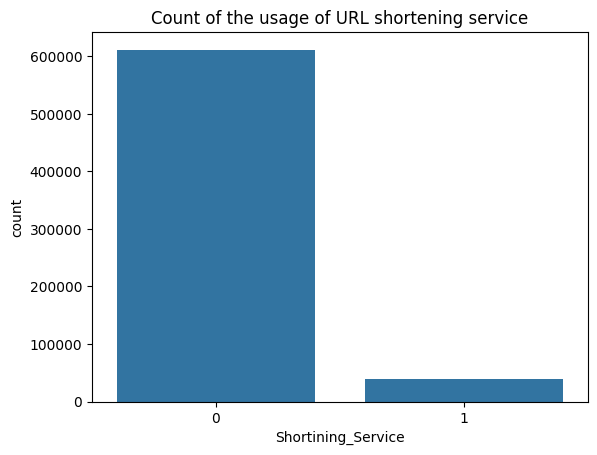

In [28]:
sns.countplot(x='Shortining_Service', data=df);
plt.title('Count of the usage of URL shortening service')

# New Section

In [29]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0


df['having_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))


df['having_ip_address'].value_counts()

0    638703
1     12488
Name: having_ip_address, dtype: int64

In [30]:
df


,url,type,Category,url_length,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,0,0,0,0,3,...,0,0,0,0,0,0,12,21,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,0,0,2,0,2,...,0,0,0,0,0,0,7,29,1,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,0,0,0,0,1,...,0,0,0,0,0,0,3,30,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,0,0,0,0,2,...,0,0,0,0,0,0,0,36,0,0


In [31]:
X = df.drop(['url','type','Category','domain'], axis = 1)
y = df['Category']
print(X)
print(y)

        url_length  @  ?  -  =  .  #  %  +  $  !  *  ,  //  abnormal_url  \
0               16  0  0  1  0  2  0  0  0  0  0  0  0   0             0   
1               35  0  0  0  0  2  0  0  0  0  0  0  0   0             0   
2               31  0  0  0  0  2  0  0  0  0  0  0  0   0             0   
3               84  0  1  1  4  2  0  0  0  0  0  0  0   1             1   
4              235  0  1  1  3  2  0  0  0  0  0  0  0   1             1   
...            ... .. .. .. .. .. .. .. .. .. .. .. ..  ..           ...   
651186          39  0  0  0  0  3  0  0  0  0  0  0  0   0             0   
651187          44  0  0  2  0  2  0  0  0  0  0  0  0   0             0   
651188          38  0  0  0  0  1  0  0  0  0  0  0  0   0             0   
651189          45  0  0  0  0  2  0  0  0  0  0  0  0   0             0   
651190          37  0  0  0  0  1  0  0  0  0  0  0  0   0             0   

        https  digits  letters  Shortining_Service  having_ip_address  
0           0  

Train & Test Split

In [32]:
print(df)

                                                      url        type  \
0                                        br-icloud.com.br    phishing   
1                     mp3raid.com/music/krizz_kaliko.html      benign   
2                         bopsecrets.org/rexroth/cr/1.htm      benign   
3       http://garage-pirenne.be/index.php?option=com_...  defacement   
4       http://adventure-nicaragua.net/index.php?optio...  defacement   
...                                                   ...         ...   
651186            xbox360.ign.com/objects/850/850402.html    phishing   
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing   
651188             gamespot.com/xbox360/action/deadspace/    phishing   
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing   
651190              angelfire.com/goth/devilmaycrytonite/    phishing   

        Category  url_length                   domain  @  ?  -  =  .  ...  !  \
0              2          16         br-icl

In [33]:
print(df.head(20))

                                                  url        type  Category  \
0                                    br-icloud.com.br    phishing         2   
1                 mp3raid.com/music/krizz_kaliko.html      benign         0   
2                     bopsecrets.org/rexroth/cr/1.htm      benign         0   
3   http://garage-pirenne.be/index.php?option=com_...  defacement         1   
4   http://adventure-nicaragua.net/index.php?optio...  defacement         1   
5   http://buzzfil.net/m/show-art/ils-etaient-loin...      benign         0   
6       espn.go.com/nba/player/_/id/3457/brandon-rush      benign         0   
7      yourbittorrent.com/?q=anthony-hamilton-soulife      benign         0   
8            http://pashminaonline.com/pure-pashminas  defacement         1   
9       allmusic.com/album/crazy-from-the-heat-r16990      benign         0   
10  corporationwiki.com/Ohio/Columbus/frank-s-bens...      benign         0   
11  http://ikenmijnkunst.nl/index.php/exposities/e..

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [35]:
print(y_train)

615699    2
24788     1
392588    0
168027    1
448154    0
         ..
84434     0
437782    0
620104    2
203245    0
100879    3
Name: Category, Length: 455833, dtype: int64


In [36]:
print

<function print>

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(pred, y_test)

# Print the formatted output
print('#############################################')
print("######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'>")
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification_report")
print(classification_report(y_test, pred))
print('###################- End -###################')


#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Test Accuracy: 90.74%
Classification_report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    128461
           1       0.93      0.96      0.94     28882
           2       0.80      0.56      0.66     28171
           3       0.94      0.90      0.92      9844

    accuracy                           0.91    195358
   macro avg       0.89      0.85      0.87    195358
weighted avg       0.90      0.91      0.90    195358

###################- End -###################


In [38]:
print(y.unique())

[2 0 1 3]


# function to plot the decision tree

In [39]:
# # Function to plot the decision tree
# def plot_decision_tree(clf_object, feature_names, class_names):
# 	plt.figure(figsize=(15, 10))
# 	tree.plot_tree(clf_object, filled=True, feature_names=feature_names, class_names=class_names, rounded=True)
# 	plt.show()

# plot_decision_tree(model, X.columns, ['2',  '0',  '1',  '3'])

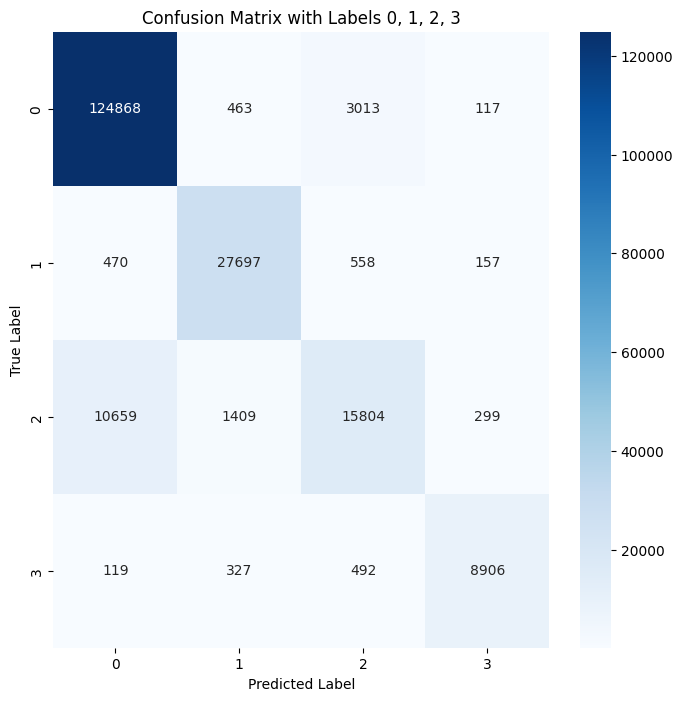

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define your labels
labels = [0, 1, 2, 3]

# # Generate predictions (replace this with your actual predictions)
# y_test = [0, 1, 2, 3, 0, 1, 2, 3]
# predictions = [0, 1, 2, 3, 0, 1, 2, 3]

# Calculate confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Labels 0, 1, 2, 3')
plt.show()